In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import warnings
from matplotlib.patches import Rectangle

warnings.filterwarnings('ignore')

df = pd.read_csv('../../data/cleaned_data/data_batch_only.csv', index_col='answer_id')

df.sample(5)

,model_name,provider_country,licence_type,map_code,graphical_complexity,viz_technique,symbol_scaling,diagram_structure,map_source,question_id,nuts_level,map_usage_type,task_type,test_mode,score
answer_id,,,,,,,,,,,,,,,
1107,Claude 3.7 Sonnet,USA,paid,MULTI-G-INST-1,high,NaN,proportional symbols,structural,statistical_office,99,country,interpretation,predict,batch,4.25
2047,MiniMax-01,China,free,SINGLE-D-ATL-1,low,cartogram,NaN,NaN,atlas,31,region,analysis,compare,batch,5.00
459,Gemini 1.5 Pro,USA,paid,SINGLE-G-INST-1,low,choropleth,NaN,NaN,statistical_office,27,country,interpretation,predict,batch,4.20
984,Claude 3.5 Sonnet v2,USA,paid,MULTI-D-ATL-1,high,NaN,graduated symbols,uniform,atlas,120,region,reading,retrieve value,batch,0.00
952,Claude 3.5 Sonnet v2,USA,paid,MULTI-G-ATL-2,high,NaN,graduated symbols,structural,atlas,88,country,interpretation,interpret,batch,4.50


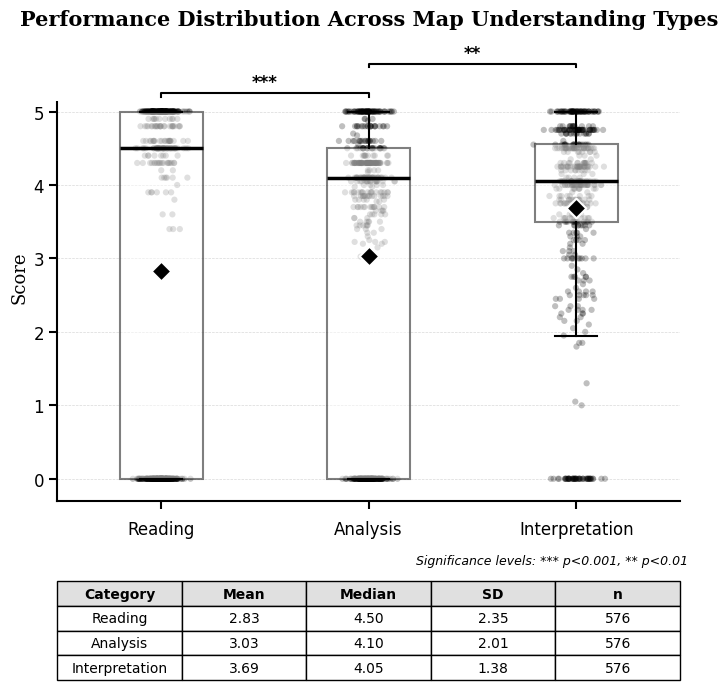

In [2]:
df_plot = df[['map_usage_type', 'score']].copy()
category_names = {
    'reading': 'Reading',
    'analysis': 'Analysis',
    'interpretation': 'Interpretation'
}
df_plot['map_usage_type'] = df_plot['map_usage_type'].map(category_names)
category_order = ['Reading', 'Analysis', 'Interpretation']

plt.style.use('default')
fig, ax = plt.subplots(figsize=(7, 7))

positions = [1, 2, 3]
bp = ax.boxplot([df_plot[df_plot['map_usage_type']==cat]['score'].values
                  for cat in category_order],
                 positions=positions,
                 labels=category_order,
                 widths=0.4,
                 patch_artist=True,
                 showfliers=False,
                 notch=False,
                 medianprops=dict(color='black', linewidth=2.5),
                 boxprops=dict(facecolor='white', edgecolor='black',
                              linewidth=1.5, alpha=0.5),
                 whiskerprops=dict(color='black', linewidth=1.5, linestyle='-'),
                 capprops=dict(color='black', linewidth=1.5))

for i, cat in enumerate(category_order, 1):
    y = df_plot[df_plot['map_usage_type']==cat]['score'].values
    x = np.random.normal(i, 0.05, size=len(y))
    ax.scatter(x, y, alpha=0.25, s=20, color='black',
               edgecolors='none', zorder=1)

means = [df_plot[df_plot['map_usage_type']==cat]['score'].mean()
         for cat in category_order]
ax.scatter(positions, means, marker='D', s=100, color='black',
           zorder=5, label='Mean', edgecolors='white', linewidths=1.5)

ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='gray', linewidth=0.5)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylabel('Score', fontsize=13, fontweight='normal', fontfamily='serif')
ax.set_xlabel('', fontsize=13, fontweight='normal', fontfamily='serif')
ax.set_title('Performance Distribution Across Map Understanding Types',
             fontsize=15, fontweight='bold', fontfamily='serif', pad=20)

ax.set_ylim(-0.3, 5.8)
ax.set_xlim(0.5, 3.5)

ax.tick_params(axis='both', which='major', labelsize=12,
              length=6, width=1.5, direction='out')
ax.tick_params(axis='x', which='major', pad=8)

def add_significance_line(ax, x1, x2, y, text):
    h = 0.05
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2)*.5, y+h+0.03, text,
            ha='center', va='bottom', color='k', fontsize=12, fontweight='bold')

label_to_idx = {cat: pos for cat, pos in zip(category_order, positions)}

y_max = df_plot['score'].max()

add_significance_line(ax,
                      label_to_idx['Analysis'],
                      label_to_idx['Reading'],
                      y_max + 0.2,
                      '***')   # p < 0.001

add_significance_line(ax,
                      label_to_idx['Interpretation'],
                      label_to_idx['Analysis'],
                      y_max + 0.6,
                      '**')    # p < 0.01

# -----------------------------

table_data = []
for cat in category_order:
    data = df_plot[df_plot['map_usage_type']==cat]['score'].values
    table_data.append([
        cat,
        f"{np.mean(data):.2f}",
        f"{np.median(data):.2f}",
        f"{np.std(data):.2f}",
        f"{len(data)}"
    ])

table = ax.table(cellText=table_data,
                colLabels=['Category', 'Mean', 'Median', 'SD', 'n'],
                cellLoc='center',
                loc='bottom',
                bbox=[0.0, -0.40, 1.0, 0.22])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.8)

for i in range(len(table_data) + 1):
    for j in range(5):
        cell = table[(i, j)]
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
        if i == 0:
            cell.set_facecolor('#e0e0e0')
            cell.set_text_props(weight='bold')
        else:
            cell.set_facecolor('white')

legend_text = 'Significance levels: *** p<0.001, ** p<0.01'
fig.text(0.99, 0.19, legend_text, ha='right', fontsize=9, style='italic')

white_cover = Rectangle((0.45, 5.15), 0.08, 1,
                        facecolor='white',
                        edgecolor='none',
                        transform=ax.transData,
                        zorder=100,
                        clip_on=False)

ax.add_patch(white_cover)

plt.tight_layout()
plt.subplots_adjust(bottom=0.28, top=0.92)

plt.savefig('../../results/plots/figure2.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

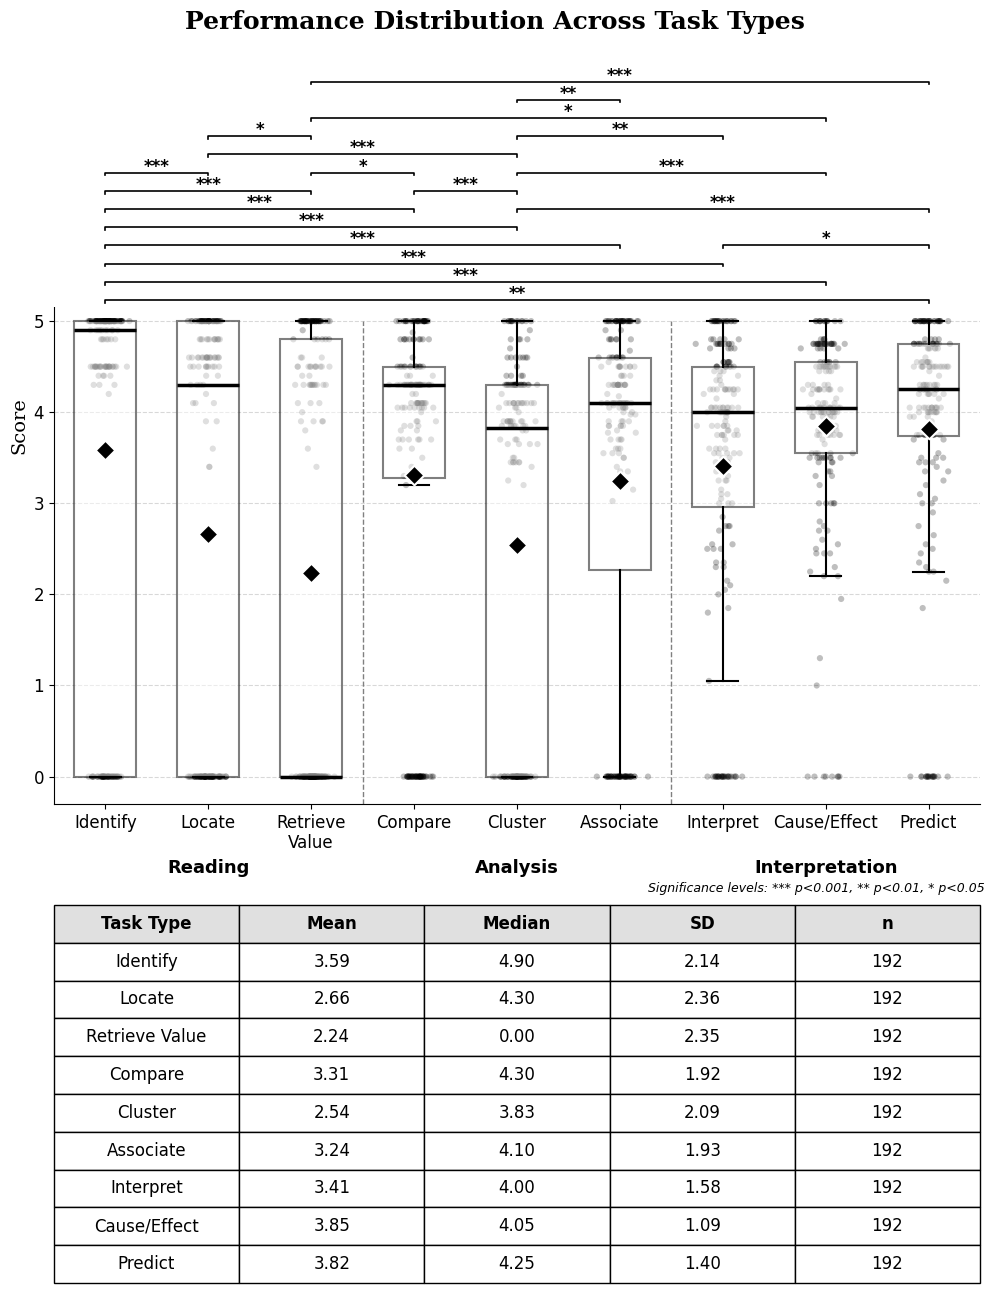

In [3]:
df_plot = df[['task_type', 'score']].copy()

operations_groups = {
    'Reading\n': ['identify', 'locate', 'retrieve value'],
    'Analysis\n': ['compare', 'cluster', 'associate'],
    'Interpretation\n': ['interpret', 'cause/effect', 'predict']
}

operation_labels_plot = {
    'identify': 'Identify',
    'locate': 'Locate',
    'retrieve value': 'Retrieve\nValue',
    'compare': 'Compare',
    'cluster': 'Cluster',
    'associate': 'Associate',
    'interpret': 'Interpret',
    'cause/effect': 'Cause/Effect',
    'predict': 'Predict'
}

operation_labels_table = {
    'identify': 'Identify',
    'locate': 'Locate',
    'retrieve value': 'Retrieve Value',
    'compare': 'Compare',
    'cluster': 'Cluster',
    'associate': 'Associate',
    'interpret': 'Interpret',
    'cause/effect': 'Cause/Effect',
    'predict': 'Predict'
}


significant_pairs = [
    ("identify", "predict", "**"),
    ("cause/effect", "identify", "***"),
    ("identify", "interpret", "***"),
    ("associate", "identify", "***"),
    ("cluster", "identify", "***"),
    ("compare", "identify", "***"),
    ("cluster", "predict", "***"),
    ("cluster", "compare", "***"),
    ("cause/effect", "cluster", "***"),
    ("identify", "retrieve value", "***"),
    ("identify", "locate", "***"),
    ("cluster", "locate", "***"),
    ("cluster", "interpret", "**"),
    ("cause/effect", "retrieve value", "*"),
    ("interpret", "predict", "*"),
    ("associate", "cluster", "**"),
    ("predict", "retrieve value", "***"),
    ("compare", "retrieve value", "*"),
    ("locate", "retrieve value", "*"),
]


def add_significance_line(ax, x1, x2, y, sig_level):
    ax.plot([x1, x1, x2, x2], [y, y+0.03, y+0.03, y], 'k-', linewidth=1.2)
    ax.text((x1+x2)/2, y-0.003, sig_level, ha='center', va='bottom', fontsize=12, fontweight='bold')


plt.style.use('default')
fig, axes = plt.subplots(2, 1, figsize=(10, 14), gridspec_kw={'height_ratios':[2,1]})
ax = axes[0]

all_data = []
all_labels = []
all_stats = []

for group_name, operations in operations_groups.items():
    for op in operations:
        op_data = df_plot[df_plot['task_type'] == op]['score'].values
        if len(op_data) > 0:
            all_data.append(op_data)
            all_labels.append(operation_labels_plot[op])
            all_stats.append([
                operation_labels_table[op],
                f"{np.mean(op_data):.2f}",
                f"{np.median(op_data):.2f}",
                f"{np.std(op_data):.2f}",
                f"{len(op_data)}"
            ])

positions = list(range(1, len(all_data)+1))
bp = ax.boxplot(all_data,
                positions=positions,
                labels=all_labels,
                widths=0.6,
                patch_artist=True,
                showfliers=False,
                notch=False,
                medianprops=dict(color='black', linewidth=2.5),
                boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.5, alpha=0.5),
                whiskerprops=dict(color='black', linewidth=1.5, linestyle='-'),
                capprops=dict(color='black', linewidth=1.5))

for i, data in enumerate(all_data, 1):
    y = data
    x = np.random.normal(i, 0.08, size=len(y))
    ax.scatter(x, y, alpha=0.25, s=20, color='black', edgecolors='none', zorder=1)

label_to_idx = {op: i+1 for i, op in enumerate(operation_labels_table.keys())}

used_segments = []
y_base = y_max + 0.2
y_step = 0.2

for op1, op2, sig in significant_pairs:
    if op1 in label_to_idx and op2 in label_to_idx:
        x1 = label_to_idx[op1]
        x2 = label_to_idx[op2]
        seg = (min(x1, x2), max(x1, x2))

        y = y_base
        while any(not (seg[1] < s[0] or seg[0] > s[1]) and abs(y - s[2]) < 1e-6 for s in used_segments):
            y += y_step

        add_significance_line(ax, seg[0], seg[1], y, sig)
        used_segments.append((seg[0], seg[1], y))

means = [np.mean(d) for d in all_data]
ax.scatter(positions, means, marker='D', s=100, color='black', zorder=5, edgecolors='white', linewidths=1.5)

ax.set_ylim(-0.3, 8.0)
ax.set_ylabel("Score", fontsize=14, fontfamily='serif')
ax.tick_params(axis='x', rotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
yticks = ax.get_yticks()

yticks_filtered = [y for y in yticks if 0 <= y <= 5]

ax.set_yticks(yticks_filtered)
ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='gray')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

group_sizes = [len(operations_groups[g]) for g in operations_groups]
group_names = list(operations_groups.keys())
current_pos = 0
for group_name, gsize in zip(group_names, group_sizes):
    x1 = current_pos + 1
    x2 = current_pos + gsize
    y = -0.7
    ax.annotate("", xy=(x1, y), xycoords='data',
                xytext=(x2, y), textcoords='data',
                arrowprops=dict(arrowstyle='-[,widthB=5.0,lengthB=0.8', lw=2))
    ax.text((x1+x2)/2, y-0.2, group_name, ha='center', va='top', fontsize=13, fontweight='bold')
    current_pos += gsize

y_end = 5
y_axis_min, y_axis_max = ax.get_ylim()
ymax_norm = (y_end - y_axis_min) / (y_axis_max - y_axis_min)

ax.axvline(x=3.5, color='gray', linestyle='--', linewidth=1, ymin=0, ymax=ymax_norm)
ax.axvline(x=6.5, color='gray', linestyle='--', linewidth=1, ymin=0, ymax=ymax_norm)

legend_text = 'Significance levels: *** p<0.001, ** p<0.01, * p<0.05'
fig.text(0.99, 0.29, legend_text, ha='right', fontsize=9, style='italic')

# ------

ax_table = axes[1]
ax_table.axis('off')

table = ax_table.table(cellText=all_stats,
                     colLabels=['Task Type', 'Mean', 'Median', 'SD', 'n'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0.0, 0.0, 1.0, 1.0])

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.8)

for i in range(len(all_stats) + 1):
    for j in range(5):
        cell = table[(i, j)]
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
        if i == 0:
            cell.set_facecolor('#e0e0e0')
            cell.set_text_props(weight='bold')


white_cover = Rectangle((0.45, 5.15), 0.08, 3,
                        facecolor='white',
                        edgecolor='none',
                        transform=ax.transData,
                        zorder=100,
                        clip_on=False)

ax.add_patch(white_cover)

fig.suptitle("Performance Distribution Across Task Types",
             fontsize=18, fontweight='bold', fontfamily='serif', y=0.92)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig("../../results/plots/figure3.png", dpi=600, bbox_inches="tight", facecolor="white")
plt.show()

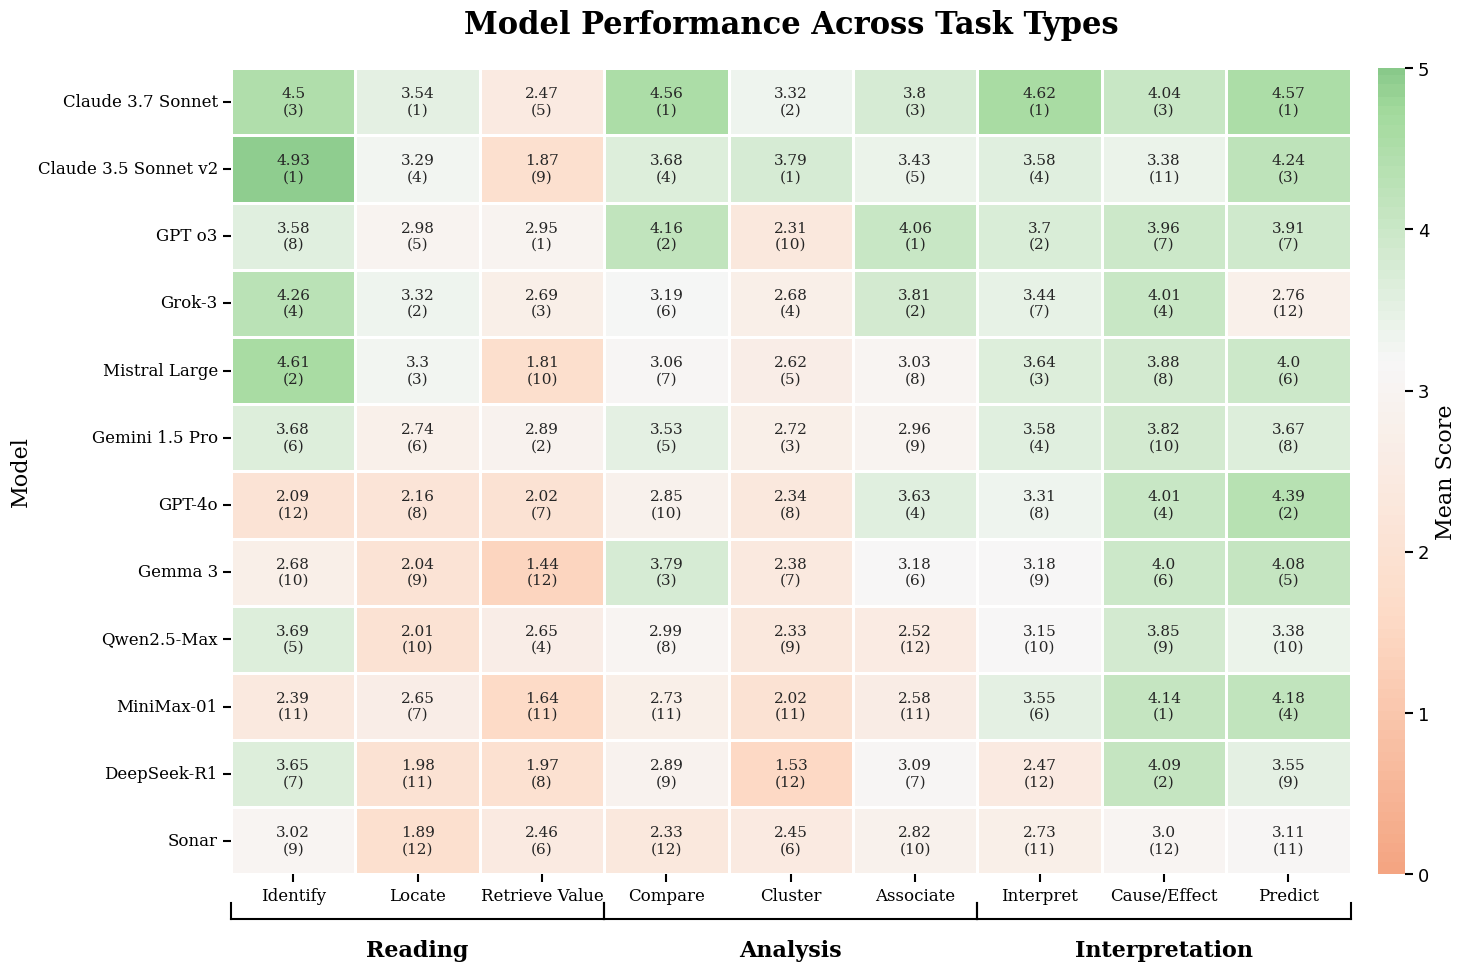

In [4]:
task_stats = df.groupby(['model_name', 'task_type'])['score'].mean().round(2)
task_pivot = task_stats.reset_index().pivot(index='model_name', columns='task_type', values='score')

desired_order = ['identify', 'locate', 'retrieve value', 'compare', 'cluster',
                 'associate', 'interpret', 'cause/effect', 'predict']

available_columns = [col for col in desired_order if col in task_pivot.columns]
task_pivot = task_pivot[available_columns]

task_pivot['overall'] = task_pivot.mean(axis=1)
overall_mean = task_pivot['overall'].mean()
task_pivot = task_pivot.sort_values('overall', ascending=False)
task_pivot = task_pivot.drop('overall', axis=1)

rank_pivot = task_pivot.rank(axis=0, ascending=False, method='min').astype(int)
annot_labels = task_pivot.round(2).astype(str) + '\n(' + rank_pivot.astype(str) + ')'

colors =['#f4a582', '#fddbc7', '#f7f7f7', '#a1d99b', '#006d2c']
cmap = LinearSegmentedColormap.from_list('grayscale_elegant', colors, N=100)

plt.style.use('default')
fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(task_pivot,
            annot=annot_labels,
            fmt='',
            cmap=cmap,
            center=overall_mean,
            vmin=0,
            vmax=5,
            cbar_kws={
                'label': 'Mean Score',
                'shrink': 1.0,
                'pad': 0.02,
                'aspect': 30
            },
            linewidths=1,
            annot_kws={'fontsize': 11, 'fontfamily': 'serif'},
            ax=ax,
            square=False)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13, width=1.5, length=6)
cbar.set_label('Mean Score', fontsize=16, fontweight='normal', fontfamily='serif')

ax.set_title('Model Performance Across Task Types',
             fontsize=22, fontweight='bold', pad=25, fontfamily='serif')

ax.set_xlabel('', fontsize=13)
ax.set_ylabel('Model', fontsize=16, fontweight='normal', fontfamily='serif')

ax.tick_params(axis='x', labelsize=12, length=6, width=1.5)
ax.tick_params(axis='y', labelsize=12, length=6, width=1.5, rotation=0)

current_labels = [label.get_text().title() for label in ax.get_xticklabels()]
ax.set_xticklabels(current_labels, fontfamily='serif')
ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif')

def add_bracket_clean(ax, start, end, y, height, label):
    ax.plot([start, start], [y, y+height], color='black', linewidth=1.5,
            clip_on=False, transform=ax.transAxes)
    ax.plot([start, end], [y, y], color='black', linewidth=1.5,
            clip_on=False, transform=ax.transAxes)
    ax.plot([end, end], [y, y+height], color='black', linewidth=1.5,
            clip_on=False, transform=ax.transAxes)

    ax.text((start+end)/2, y-0.025, label, ha='center', va='top',
            fontsize=16, fontweight='bold', transform=ax.transAxes,
            fontfamily='serif')

n_tasks = len(available_columns)
task_width = 1.0 / n_tasks
y_pos = -0.055
bracket_height = 0.02

add_bracket_clean(ax, 0, 3*task_width, y_pos, bracket_height, 'Reading')
add_bracket_clean(ax, 3*task_width, 6*task_width, y_pos, bracket_height, 'Analysis')
add_bracket_clean(ax, 6*task_width, 9*task_width, y_pos, bracket_height, 'Interpretation')

ax.grid(False)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

plt.savefig('../../results/plots/appendix3.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

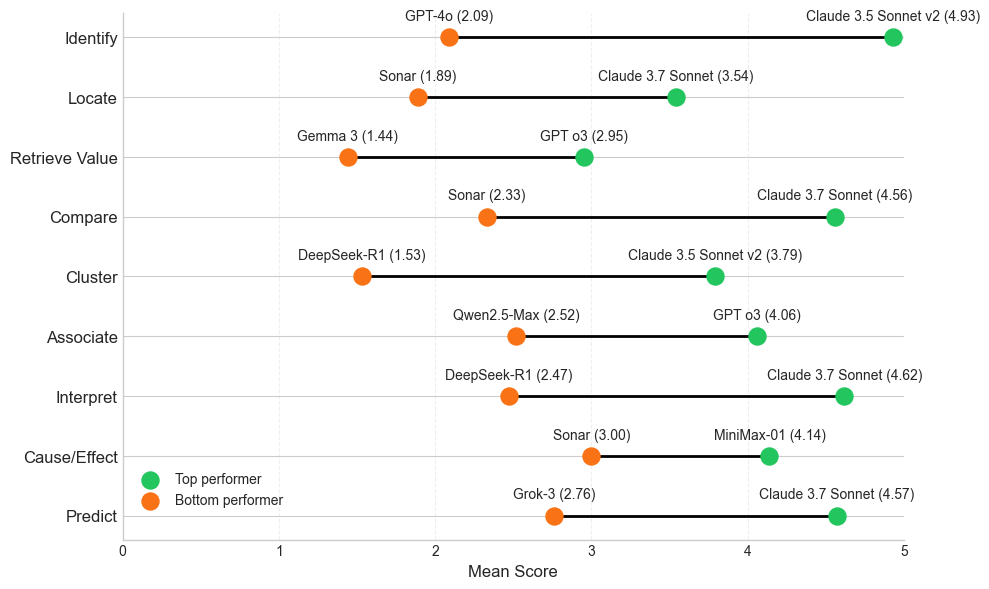

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


desired_order = ['identify', 'locate', 'retrieve value', 'compare', 'cluster',
                 'associate', 'interpret', 'cause/effect', 'predict']

available_columns = [col for col in desired_order if col in task_pivot.columns]
task_pivot = task_pivot[available_columns]


top_performers = task_pivot.idxmax()   # nazwa modelu z najwyższym wynikiem
bottom_performers = task_pivot.idxmin()  # nazwa modelu z najniższym wynikiem

top_scores = task_pivot.max()
bottom_scores = task_pivot.min()

fig, ax = plt.subplots(figsize=(10, 6))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for i, task in enumerate(task_pivot.columns):
    # linia łącząca top i bottom
    ax.plot([bottom_scores[task], top_scores[task]], [i, i], color="#000000", zorder=1, linewidth=2)
    # punkty top
    ax.scatter(top_scores[task], i, color="#22c55e", s=150, zorder=2)
    # punkty bottom
    ax.scatter(bottom_scores[task], i, color="#f97316", s=150, zorder=3)
    # podpisy modeli z wartością w nawiasie
    ax.text(top_scores[task], i-0.35, f"{top_performers[task]} ({top_scores[task]:.2f})",
            va='center', ha='center', fontsize=10)
    ax.text(bottom_scores[task], i-0.35, f"{bottom_performers[task]} ({bottom_scores[task]:.2f})",
            va='center', ha='center', fontsize=10)

ax.set_xlim(0,5)
ax.set_yticks(range(len(task_pivot.columns)))
ax.set_yticklabels([t.title() for t in task_pivot.columns], fontsize=12)
ax.invert_yaxis()
ax.set_xlabel("Mean Score", fontsize=12)

ax.grid(axis='x', linestyle='--', alpha=0.3)

ax.scatter([], [], color="#22c55e", s=150, label='Top performer')
ax.scatter([], [], color="#f97316", s=150, label='Bottom performer')
ax.legend(loc=(0.01,0.05))

plt.savefig('../../results/plots/dumbbell-plot.png', dpi=300, bbox_inches='tight', facecolor='white')


plt.tight_layout()
plt.show()


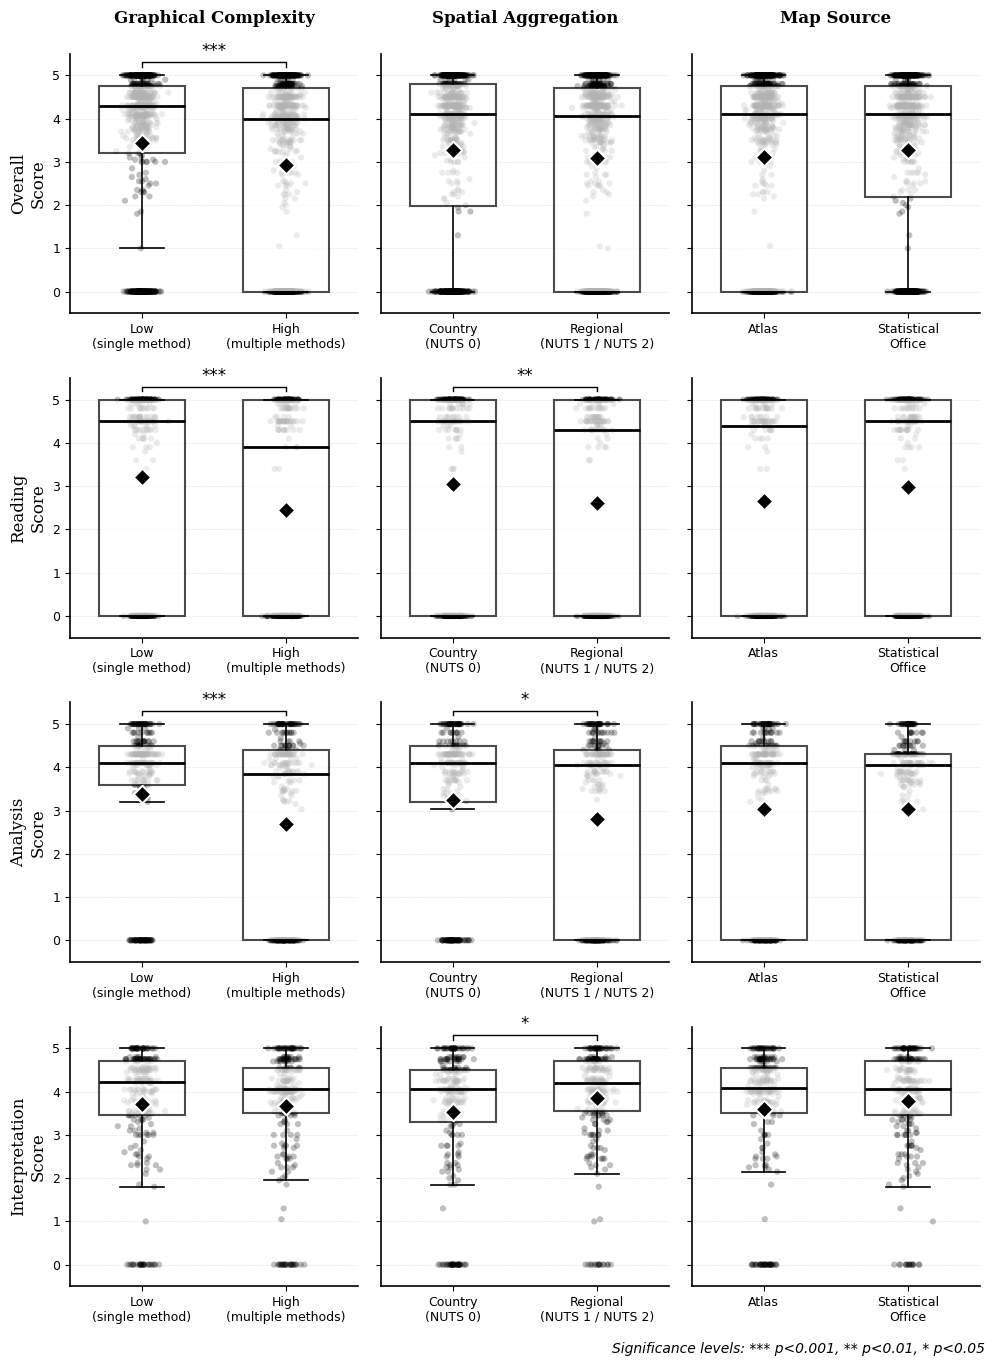

In [5]:
def add_significance_line(ax, x1, x2, y, sig_level):
    if not sig_level:
        return
    ax.plot([x1, x1, x2, x2], [y, y+0.1, y+0.1, y], 'k-', linewidth=1)
    ax.text((x1+x2)/2, y+0.15, sig_level, ha='center', va='bottom', fontsize=12)


fig, axes = plt.subplots(4, 3, figsize=(10, 14))
plt.style.use('default')

characteristics = [
    ('graphical_complexity', 'Graphical Complexity\n', ['low', 'high']),
    ('nuts_level', 'Spatial Aggregation\n', ['country', 'region']),
    ('map_source', 'Map Source\n', ['atlas', 'statistical_office'])
]

row_categories = [
    ('overall', 'Overall'),
    ('reading', 'Reading'),
    ('analysis', 'Analysis'),
    ('interpretation', 'Interpretation')
]

significance_levels = {
    'graphical_complexity': {'overall': '***', 'reading': '***', 'analysis': '***', 'interpretation': None},
    'nuts_level': {'overall': None, 'reading': '**', 'analysis': '*', 'interpretation': '*'},
    'map_source': {'overall': None, 'reading': None, 'analysis': None, 'interpretation': None}
}

for row_idx, (row_cat, row_label) in enumerate(row_categories):
    for col_idx, (col, col_title, order) in enumerate(characteristics):
        ax = axes[row_idx, col_idx]

        data_for_plot = []
        tick_labels = []

        if row_cat == 'overall':
            df_filtered = df
        else:
            df_filtered = df[df['map_usage_type'] == row_cat]

        for category in order:
            category_data = df_filtered[df_filtered[col] == category]['score'].dropna().values

            if len(category_data) > 0:
                data_for_plot.append(category_data)
            else:
                data_for_plot.append(np.array([]))

            if col == 'graphical_complexity':
                label = 'Low\n(single method)' if category == 'low' else 'High\n(multiple methods)'
            elif col == 'nuts_level':
                label = 'Country\n(NUTS 0)' if category == 'country' else 'Regional\n(NUTS 1 / NUTS 2)'
            else:
                label = 'Atlas' if category == 'atlas' else 'Statistical\nOffice'
            tick_labels.append(label)

        bp = ax.boxplot(data_for_plot,
                        labels=tick_labels,
                        widths=0.6,
                        patch_artist=True,
                        showfliers=False,
                        notch=False,
                        medianprops=dict(color='black', linewidth=2),
                        boxprops=dict(facecolor='white', edgecolor='black',
                                     linewidth=1.5, alpha=0.7),
                        whiskerprops=dict(color='black', linewidth=1.2),
                        capprops=dict(color='black', linewidth=1.2))

        for i, data in enumerate(data_for_plot, 1):
            if len(data) > 0:
                y = data
                x = np.random.normal(i, 0.05, size=len(y))
                ax.scatter(x, y, alpha=0.25, s=20, color='black',
                      edgecolors='none', zorder=1)

        means = []
        positions = []
        for i, data in enumerate(data_for_plot, 1):
            if len(data) > 0:
                means.append(np.mean(data))
                positions.append(i)

        if means:
            ax.scatter(positions, means, marker='D', s=80, color='black',
                      zorder=5, edgecolors='white', linewidths=1.5)

        sig_level = significance_levels[col][row_cat]
        if sig_level:
            max_y = max([np.max(d) if len(d) > 0 else 0 for d in data_for_plot])
            add_significance_line(ax, 1, 2, max_y + 0.2, sig_level)

        ax.yaxis.grid(True, linestyle='--', alpha=0.2, color='gray', linewidth=0.5)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)

        if row_idx == 0:
            ax.set_title(col_title, fontsize=12, fontweight='bold', fontfamily='serif', pad=8)

        if col_idx == 0:
            ax.set_ylabel(row_label + '\nScore', fontsize=12, fontfamily='serif')
        else:
            ax.set_ylabel('')

        ax.set_ylim(-0.5, 5.5)
        ax.tick_params(axis='x', labelsize=9, rotation=0)
        ax.tick_params(axis='y', labelsize=9)

        if col_idx > 0:
            ax.set_yticklabels([])

# fig.suptitle('Performance Distribution Across Principal Map Characteristics\nand Map Understanding Types',
#              fontsize=15, fontweight='bold', fontfamily='serif', y=1.00)

legend_text = 'Significance levels: *** p<0.001, ** p<0.01, * p<0.05'
fig.text(0.99, 0.01, legend_text, ha='right', fontsize=10, style='italic')

plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.savefig('../../results/plots/figure4.png',
            dpi=1000,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none',
            format='png',
            transparent=False)
plt.show()


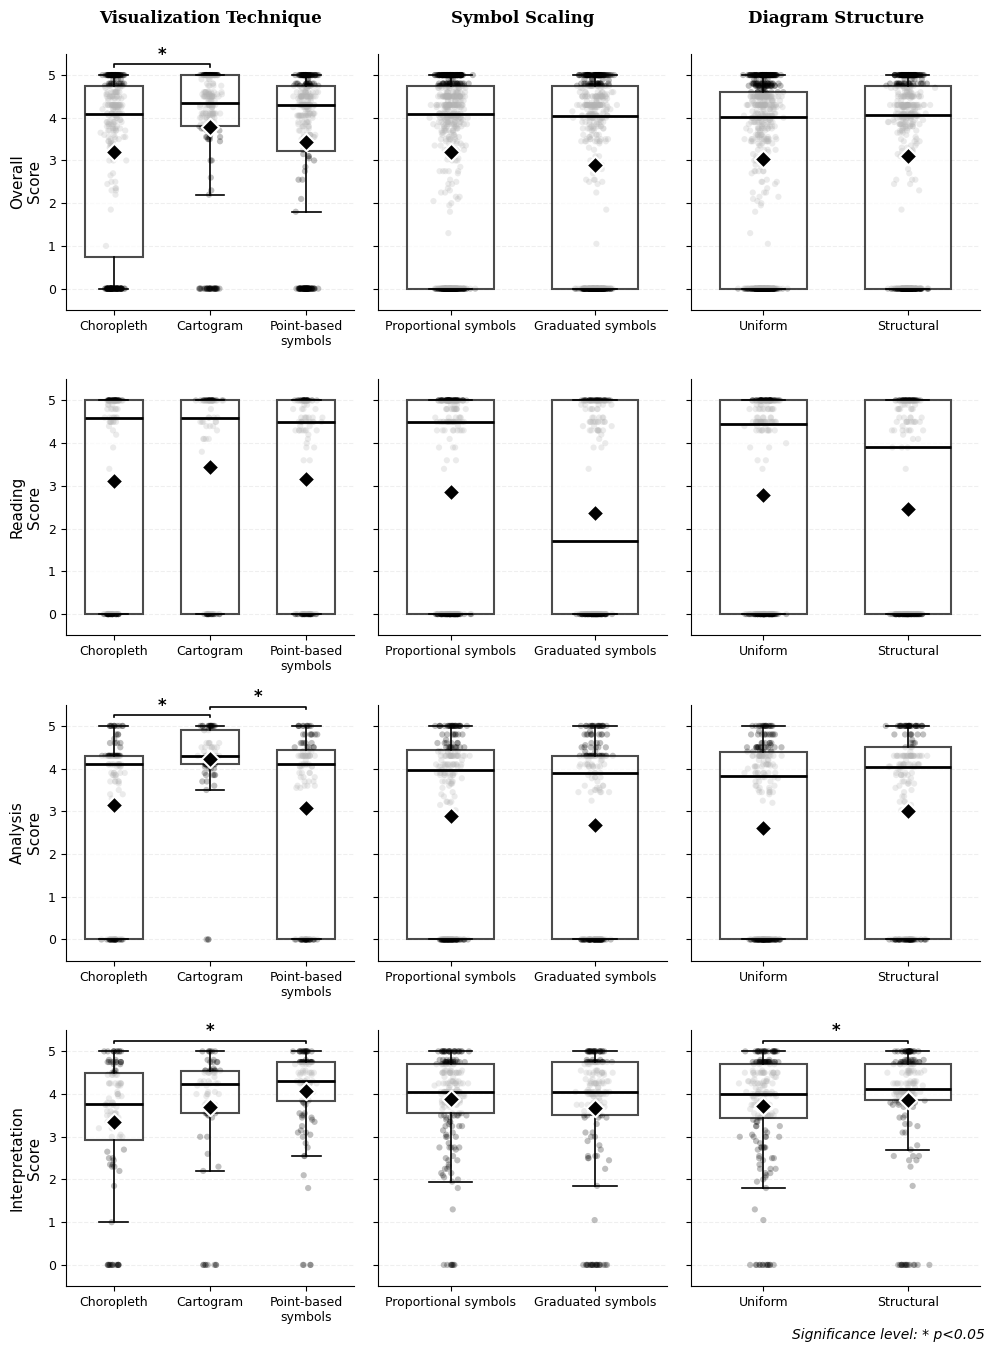

In [6]:
viz_map = {'choropleth': 'Choropleth', 'cartogram': 'Cartogram', 'point-based symbols': 'Point-based\nsymbols'}
symbol_map = {'graduated symbols': 'Graduated symbols', 'proportional symbols': 'Proportional symbols'}
structure_map = {'uniform': 'Uniform', 'structural': 'Structural'}

df['Visualization'] = df['viz_technique'].map(viz_map)
df['SymbolScaling'] = df['symbol_scaling'].map(symbol_map)
df['DiagramStructure'] = df['diagram_structure'].map(structure_map)

def add_significance_line(ax, x1, x2, y, sig_level):
    if not sig_level:
        return
    ax.plot([x1, x1, x2, x2], [y, y+0.05, y+0.05, y], 'k-', linewidth=1.2)
    ax.text((x1+x2)/2, y+0.06, sig_level, ha='center', va='bottom', fontsize=12, fontweight='bold')

fig, axes = plt.subplots(4, 3, figsize=(10, 14))
plt.style.use('default')

characteristics = [
    ('Visualization', 'Visualization Technique\n', ['Choropleth','Cartogram','Point-based\nsymbols']),
    ('SymbolScaling', 'Symbol Scaling\n', ['Proportional symbols','Graduated symbols']),
    ('DiagramStructure', 'Diagram Structure\n', ['Uniform','Structural'])
]

row_categories = [
    ('overall', 'Overall'),
    ('reading', 'Reading'),
    ('analysis', 'Analysis'),
    ('interpretation', 'Interpretation')
]

significant_pairs = {
    'Visualization': {
        'overall': [('Cartogram','Choropleth','*')],
        'reading': [],
        'analysis': [('Cartogram','Choropleth','*'),('Cartogram','Point-based\nsymbols','*')],
        'interpretation': [('Choropleth','Point-based\nsymbols','*')]
    },
    'SymbolScaling': {'overall': [], 'reading': [], 'analysis': [], 'interpretation': []},
    'DiagramStructure': {'overall': [], 'reading': [], 'analysis': [], 'interpretation': [('Uniform','Structural','*')]}
}

for row_idx, (row_cat, row_label) in enumerate(row_categories):
    for col_idx, (col, col_title, order) in enumerate(characteristics):
        ax = axes[row_idx, col_idx]

        if row_cat=='overall':
            df_filtered = df
        else:
            df_filtered = df[df['map_usage_type']==row_cat]

        data_for_plot = [df_filtered[df_filtered[col]==val]['score'].dropna().values for val in order]
        tick_labels = order

        bp = ax.boxplot(data_for_plot,
                        labels=tick_labels,
                        widths=0.6,
                        patch_artist=True,
                        showfliers=False,
                        medianprops=dict(color='black', linewidth=2),
                        boxprops=dict(facecolor='white', edgecolor='black', linewidth=1.5, alpha=0.7),
                        whiskerprops=dict(color='black', linewidth=1.2),
                        capprops=dict(color='black', linewidth=1.2))

        for i, data in enumerate(data_for_plot,1):
            if len(data)>0:
                x = np.random.normal(i, 0.05, size=len(data))
                ax.scatter(x, data, alpha=0.25, s=20, color='black', edgecolors='none', zorder=1)
        means = [np.mean(d) for d in data_for_plot if len(d)>0]
        positions = [i+1 for i,d in enumerate(data_for_plot) if len(d)>0]
        if means:
            ax.scatter(positions, means, marker='D', s=80, color='black', zorder=5, edgecolors='white', linewidths=1.5)

        for g1,g2,sig in significant_pairs[col][row_cat]:
            x1 = order.index(g1)+1
            x2 = order.index(g2)+1
            y_max = max([np.max(d) if len(d)>0 else 0 for d in data_for_plot])

            if col == 'Visualization' and g1 == 'Cartogram' and g2 == 'Point-based\nsymbols':
                add_significance_line(ax, x1, x2, y_max + 0.2 + 0.2, sig)  # 0.15 wyżej
            else:
                add_significance_line(ax, x1, x2, y_max + 0.2, sig)

        ax.set_ylim(-0.5, 5.5)
        ax.yaxis.grid(True, linestyle='--', alpha=0.2)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        if row_idx==0:
            ax.set_title(col_title, fontsize=12, fontweight='bold', fontfamily='serif', pad=8)
        if col_idx==0:
            ax.set_ylabel(row_label+'\nScore', fontsize=11)
        else:
            ax.set_yticklabels([])

        ax.tick_params(axis='x', labelsize=9, rotation=0)
        ax.tick_params(axis='y', labelsize=9)

legend_text = 'Significance level: * p<0.05'
fig.text(0.99, 0.00, legend_text, ha='right', fontsize=10, style='italic')

# fig.suptitle('Performance Across Secondary Map Characteristics and  Understanding ', fontsize=15, fontweight='bold', fontfamily='serif', y=0.97)

plt.tight_layout(rect=[0,0,1,0.96])
plt.savefig('../../results/plots/figure5.png',
            dpi=1000,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none',
            format='png',
            transparent=False)
plt.show()

In [7]:
df_profiles = pd.read_csv('../../results/model_difficulty_profiles_means.csv', index_col='model_name')
df_profiles.head()

,high_country_atlas_analysis,high_country_atlas_interpretation,high_country_atlas_reading,high_country_statistical_office_analysis,high_country_statistical_office_interpretation,high_country_statistical_office_reading,high_region_atlas_analysis,high_region_atlas_interpretation,high_region_atlas_reading,low_country_atlas_analysis,...,low_country_atlas_reading,low_country_statistical_office_analysis,low_country_statistical_office_interpretation,low_country_statistical_office_reading,low_region_atlas_analysis,low_region_atlas_interpretation,low_region_atlas_reading,low_region_statistical_office_analysis,low_region_statistical_office_interpretation,low_region_statistical_office_reading
model_name,,,,,,,,,,,,,,,,,,,,,
Claude 3.5 Sonnet v2,3.833333,2.758333,4.050000,3.494444,3.988889,3.222222,3.350000,4.083333,2.166667,3.800000,...,4.166667,4.466667,2.750000,5.000000,4.566667,4.516667,3.333333,3.333333,3.929167,3.216667
Claude 3.7 Sonnet,4.616667,4.391667,3.250000,3.894444,4.216667,3.255556,2.536111,4.455556,2.111111,3.866667,...,4.983333,4.466667,3.233333,5.000000,4.933333,4.500000,3.166667,4.158333,4.675000,3.833333
DeepSeek-R1,2.150000,2.808333,2.950000,2.350000,3.855556,1.544444,1.850000,2.827778,1.655556,2.983333,...,3.933333,3.033333,2.033333,3.333333,4.333333,4.200000,1.366667,2.458333,3.791667,3.116667
GPT o3,3.716667,3.083333,3.183333,2.658333,4.366667,2.700000,2.997222,3.216667,3.333333,4.266667,...,4.500000,4.266667,3.683333,1.666667,4.333333,4.183333,1.666667,3.654167,4.100000,3.483333
GPT-4o,3.750000,3.666667,2.350000,2.308333,4.366667,2.211111,2.241667,3.788889,1.088889,3.650000,...,2.300000,4.033333,2.350000,1.666667,4.866667,4.000000,3.166667,2.425000,4.262500,2.358333


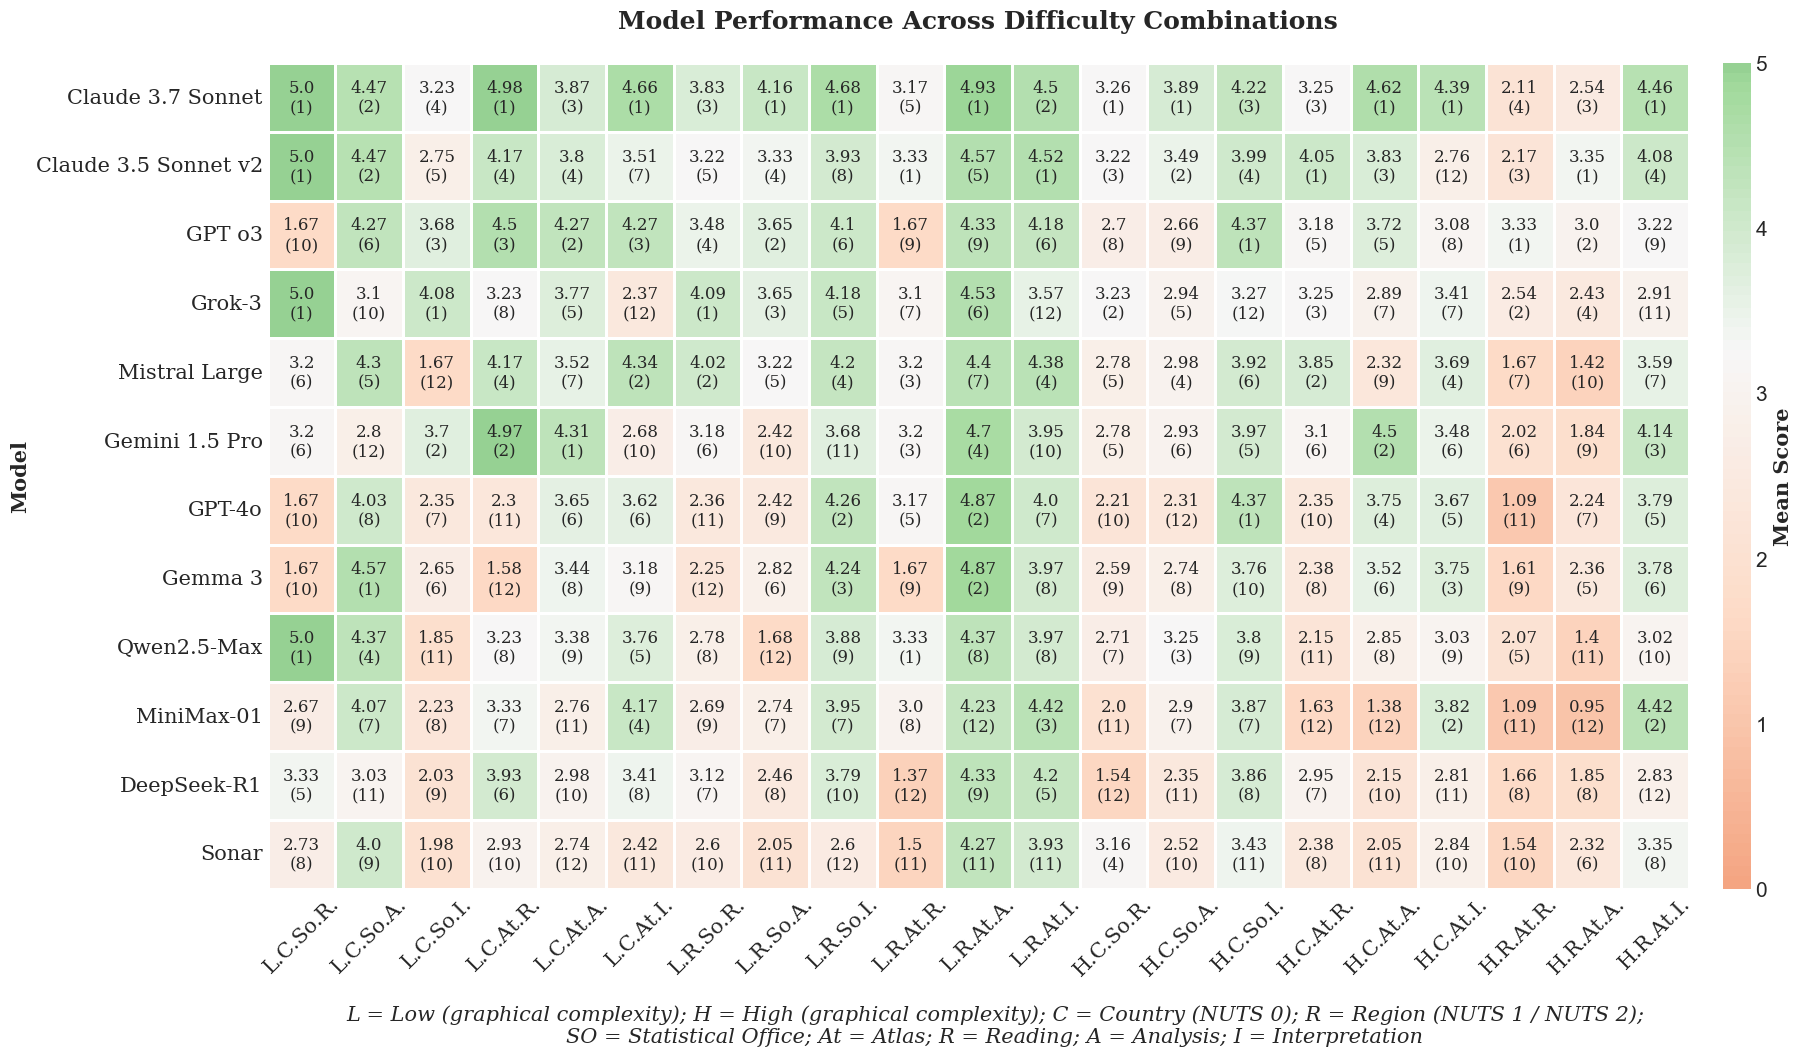

In [8]:
abbr_map = {
    'low_country_statistical_office_reading': 'L.C.SO.R.',
    'low_country_statistical_office_analysis': 'L.C.SO.A.',
    'low_country_statistical_office_interpretation': 'L.C.SO.I.',
    'low_country_atlas_reading': 'L.C.At.R.',
    'low_country_atlas_analysis': 'L.C.At.A.',
    'low_country_atlas_interpretation': 'L.C.At.I.',
    'low_region_statistical_office_reading': 'L.R.SO.R.',
    'low_region_statistical_office_analysis': 'L.R.SO.A.',
    'low_region_statistical_office_interpretation': 'L.R.SO.I.',
    'low_region_atlas_reading': 'L.R.At.R.',
    'low_region_atlas_analysis': 'L.R.At.A.',
    'low_region_atlas_interpretation': 'L.R.At.I.',
    'high_country_statistical_office_reading': 'H.C.SO.R.',
    'high_country_statistical_office_analysis': 'H.C.SO.A.',
    'high_country_statistical_office_interpretation': 'H.C.SO.I.',
    'high_country_atlas_reading': 'H.C.At.R.',
    'high_country_atlas_analysis': 'H.C.At.A.',
    'high_country_atlas_interpretation': 'H.C.At.I.',
    'high_region_atlas_reading': 'H.R.At.R.',
    'high_region_atlas_analysis': 'H.R.At.A.',
    'high_region_atlas_interpretation': 'H.R.At.I.'
}

df_profiles = df_profiles[abbr_map.keys()]
df_profiles.rename(columns=abbr_map, inplace=True)

model_order = [
    "Claude 3.7 Sonnet",
    "Claude 3.5 Sonnet v2",
    "GPT o3",
    "Grok-3",
    "Mistral Large",
    "Gemini 1.5 Pro",
    "GPT-4o",
    "Gemma 3",
    "Qwen2.5-Max",
    "MiniMax-01",
    "DeepSeek-R1",
    "Sonar"
]
df_profiles = df_profiles.loc[model_order]

vcenter = df_profiles.values.mean()

colors = ['#f4a582', '#fddbc7', '#f7f7f7', '#a1d99b', '#006d2c']
cmap = LinearSegmentedColormap.from_list('soft_rdylgn', colors, N=100)

rank_pivot = df_profiles.rank(axis=0, ascending=False, method='min').astype(int)
annot_labels = df_profiles.round(2).astype(str) + '\n(' + rank_pivot.astype(str) + ')'

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(20, 10))

sns.heatmap(df_profiles,
            annot=annot_labels,
            fmt='',
            cmap=cmap,
            center=vcenter,
            vmin=0,
            vmax=5,
            cbar_kws={'label': 'Mean Score', 'shrink': 1.0, 'pad': 0.02, 'aspect': 30},
            linewidths=1,
            linecolor='white',
            annot_kws={'fontsize': 12, 'fontfamily': 'serif'},
            ax=ax,
            square=False)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Mean Score', fontsize=15, fontweight='bold', fontfamily='serif')

ax.set_title('Model Performance Across Difficulty Combinations',
             fontsize=18, fontweight='bold', pad=25, fontfamily='serif')
ax.set_xlabel('', fontsize=15)
ax.set_ylabel('Model', fontsize=15, fontweight='bold', fontfamily='serif')
ax.tick_params(axis='x', labelsize=15, length=0, rotation=45)
ax.tick_params(axis='y', labelsize=15, length=0, rotation=0)
current_labels = [label.get_text().title() for label in ax.get_xticklabels()]
ax.set_xticklabels(current_labels, fontfamily='serif')
ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif')

def add_bracket_rounded(ax, start, end, y, height, label):
    n_points = 50
    x = np.linspace(start, end, n_points)
    bracket_y = np.ones(n_points) * y
    bracket_y[:5] = np.linspace(y + height, y, 5)
    bracket_y[-5:] = np.linspace(y, y + height, 5)
    ax.plot(x, bracket_y, color='#333333', linewidth=1, clip_on=False, transform=ax.transAxes, solid_capstyle='round')
    ax.text((start+end)/2, y-0.022, label, ha='center', va='top',
            fontsize=15, fontweight='bold', transform=ax.transAxes,
            fontfamily='serif',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.8))

n_tasks = df_profiles.shape[1]
task_width = 1.0 / n_tasks
y_pos = -0.055
bracket_height = 0.025

reading_cols = [i for i, c in enumerate(df_profiles.columns) if '_R' in c]
analysis_cols = [i for i, c in enumerate(df_profiles.columns) if '_A' in c]
interpretation_cols = [i for i, c in enumerate(df_profiles.columns) if '_I' in c]


legend_text = (
    "L = Low (graphical complexity); H = High (graphical complexity); "
    "C = Country (NUTS 0); R = Region (NUTS 1 / NUTS 2);\n"
    "SO = Statistical Office; At = Atlas; "
    "R = Reading; A = Analysis; I = Interpretation"
)

fig.text(0.5, -0.01, legend_text,
         ha='center', va='top',
         fontsize=15, style='italic',
         fontfamily='serif')

plt.tight_layout()
plt.savefig('../../results/plots/appendix4.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
